<a href="https://colab.research.google.com/github/JonHaz/Capstone-2-LVMH-Sales-in-Iowa/blob/main/LVMH_Capstone_Two_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook I will be testing out different machine learning models to predict sales

*   ARIMA
*   Linear Regression
*   Random Forest Regression
*   XGBoost
*   Long Short Term Memory

My game plan is to


*   split the data into train and test
*   create a pipeline
*   perform 5 fold cross validation
*   use gradient boosting to determine what learning rate has the best accuracy
*   Random Search to determine what is a good enough parameter

Limit the number of unique values in my dataset by grouping them

Replace a category with the average 

In [1]:
#Packages I will be using
import pandas as pd
from datetime import datetime, timedelta
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
#https://github.com/srpraveen97/Electrical_Demand_Toronto/blob/main/Jupyter%20Notebooks/LinearModel_TimeSeries.ipynb

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# I am establishing a connection to my Sandbox within BigQuery so that I can run SQL queries to interact with the data here within Google Collab
from google.colab import auth
auth.authenticate_user()
print('Authenticated')


Authenticated


In [3]:
# Save output in a variable `df`
%%bigquery --project storied-sound-253213 df
SELECT *
FROM `bigquery-public-data.iowa_liquor_sales.sales`
WHERE vendor_number = '420'

In [5]:
df.nunique()

invoice_and_item_number    298945
date                         2275
store_number                 2314
store_name                   2448
address                      3300
city                          735
zip_code                      459
store_location               1853
county_number                 108
county                        199
category                       18
category_name                  20
vendor_number                   1
vendor_name                     2
item_number                   196
item_description              185
pack                           11
bottle_volume_ml               17
state_bottle_cost             180
state_bottle_retail           185
bottles_sold                  103
sale_dollars                 1999
volume_sold_liters            221
volume_sold_gallons           272
dtype: int64

In [24]:
#applying a little data cleaning
#changing data types for 'date', 'pack', 'bottle_volume_ml'
df['date'] = pd.to_datetime(df['date'])
add_cat = ['pack', 'bottle_volume_ml']
df[add_cat] = df[add_cat].astype(str)
#removing fields that are unique identifiers, are redundant, or have more than 100 unique options
# ['invoice_and_item_number' , 'vendor_number','vendor_name', 'store_name', 'address','item_description', 'item_number', 'store_number', 'city', 'zip_code', 'store_location', 'county_number', 'county']
remove_cat = ['invoice_and_item_number' , 'vendor_number','vendor_name', 'store_name', 'address','item_description', 'item_number', 'store_number', 'city', 'zip_code', 'store_location', 'county_number', 'county']
df_cat = df.drop(columns=remove_cat)

In [27]:
# select object type columns
dfo=df_cat.select_dtypes(include=['object']) 
df = pd.concat([df.drop(dfo, axis=1), pd.get_dummies(dfo)], axis=1)

In [25]:
# lets move the field 'invoice_and_item_number' to the index
df = df.set_index('invoice_and_item_number')

# creating a series of dates
df_date = df['date']

# dropping columns so that the data can be scaled
cat = ['date','store_number',	'store_name',	'address',	'city',	'zip_code',	'store_location',	'county_number',	'county',	'vendor_number',	'vendor_name',	'item_number',	'item_description']
df_scaled = df.drop(columns=cat)

In [26]:
print(df.nunique())
print(df['county_number'].unique())

date                   2275
store_number           2314
store_name             2448
address                3300
city                    735
zip_code                459
store_location         1853
county_number           108
county                  199
category                 18
category_name            20
vendor_number             1
vendor_name               2
item_number             196
item_description        185
pack                     11
bottle_volume_ml         17
state_bottle_cost       180
state_bottle_retail     185
bottles_sold            103
sale_dollars           1999
volume_sold_liters      221
volume_sold_gallons     272
dtype: int64
['77' '07' '52' '17' '70' '64' '85' '82' '86' '57' '25' '24' '97' '31'
 '44' None '7' '20' '78' '96' '14' '92' '48' '71' '59' '50' '09' '90' '51'
 '94' '88' '55' '23' '53' '9' '11' '47' '30' '62' '18' '58' '79' '93' '61'
 '29' '56' '73' '43' '42' '21' '75' '63' '65' '91' '8' '08' '46' '13' '34'
 '66' '32' '49' '28' '33' '6' '15' '27' '69' '4

In [27]:
# I created a lookup table in Google Sheets that grouped county number by district per the Iowa Department of Transportation
# I am importing that googlesheet and creating a dataframe

!pip install --upgrade -q gspread

import gspread
import pandas as pd
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())

worksheet = gc.open('Districts Iowa Department of Transportation').sheet1
rows = worksheet.get_all_values()
district = pd.DataFrame.from_records(rows)

In [28]:
#formatting the new dat frame
column = ['count_number', 'district']
district.set_axis(column, axis=1, inplace=True)
district = district.drop(0)
district.head()

,count_number,district
1,1,3
2,2,3
3,3,3
4,4,3
5,5,2


In [29]:
#merged the district df with my existing df
new_df =df.merge(district,left_on='county_number', right_on='count_number')

new_df.columns

Index(['date', 'store_number', 'store_name', 'address', 'city', 'zip_code',
       'store_location', 'county_number', 'county', 'category',
       'category_name', 'vendor_number', 'vendor_name', 'item_number',
       'item_description', 'pack', 'bottle_volume_ml', 'state_bottle_cost',
       'state_bottle_retail', 'bottles_sold', 'sale_dollars',
       'volume_sold_liters', 'volume_sold_gallons', 'count_number',
       'district'],
      dtype='object')

In [172]:
#adding new columns
new_df['year'] = pd.DatetimeIndex(new_df['date']).year
new_df['month'] = pd.DatetimeIndex(new_df['date']).month
new_df['week'] = pd.DatetimeIndex(new_df['date']).week

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  after removing the cwd from sys.path.


In [173]:
new_df.columns

Index(['date', 'store_number', 'store_name', 'address', 'city', 'zip_code',
       'store_location', 'county_number', 'county', 'category',
       'category_name', 'vendor_number', 'vendor_name', 'item_number',
       'item_description', 'pack', 'bottle_volume_ml', 'state_bottle_cost',
       'state_bottle_retail', 'bottles_sold', 'sale_dollars',
       'volume_sold_liters', 'volume_sold_gallons', 'count_number', 'district',
       'year', 'month', 'ym', 'week'],
      dtype='object')

In [175]:
sales_district_year = new_df.groupby(['district','year'])['sale_dollars'].agg('sum')
sales_district_month = new_df.groupby(['district','month'])['sale_dollars'].agg('sum')
sales_district_week = new_df.groupby(['district','ym'])['sale_dollars'].agg('sum')
#sales_district.sort_values(ascending=True).head()
sales_district_year = sales_district_year.reset_index(level='district')
sales_district_month = sales_district_month.reset_index(level='district')
sales_district_week = sales_district_week.reset_index(level='district')

In [176]:
sales_district_week.head()

,district,sale_dollars
ym,,
1,1,9006.01
2,1,7608.23
3,1,14605.84
4,1,21974.64
5,1,9518.58


Weekly sales throughout a calendar year

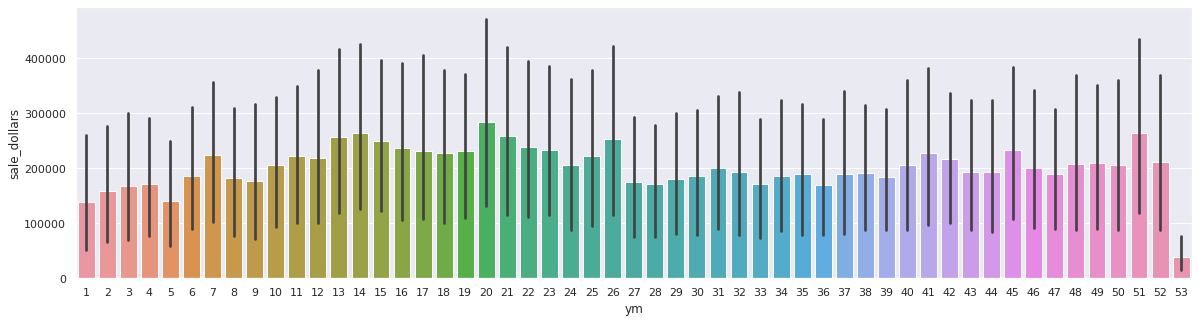

In [180]:
plt.figure(figsize=(20,5))
x = sales_district_week.index
y = sales_district_week['sale_dollars']
hue = sales_district_week['district']

sns.barplot(x=x, y=y)

In [141]:
sales_district_year.head()

,district,sale_dollars
year,,
2012,1,42745.55
2013,1,42995.90
2014,1,45753.00
2015,1,41908.83
2016,1,52867.27


[Text(0, 0.5, 'Millions'), Text(0.5, 0, 'Districts')]

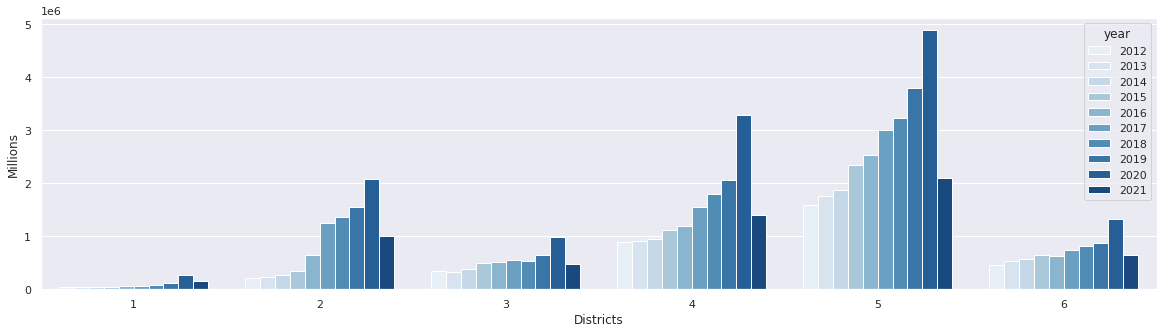

In [142]:

plt.figure(figsize=(20,5))

sns.set_theme(style="darkgrid")
x = sales_district_year['district']
y = sales_district_year['sale_dollars']
hue = sales_district_year.index
ax = sns.barplot(y=y, x=x, hue=hue, palette='Blues')

ax.set(xlabel='Districts', ylabel='Millions')

By plotting sales by ditrict over the years we can see that there is year over year sales growth.

[Text(0, 0.5, 'Millions'), Text(0.5, 0, 'Districts')]

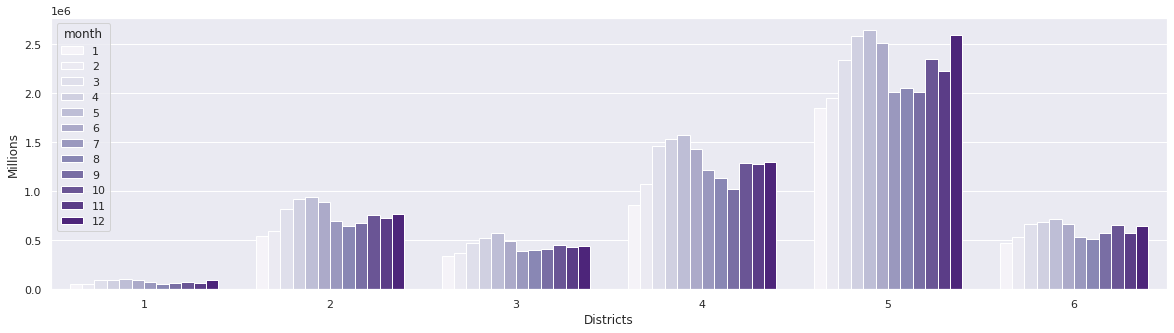

In [144]:
plt.figure(figsize=(20,5))

sns.set_theme(style="darkgrid")
x = sales_district_month['district']
y = sales_district_month['sale_dollars']
hue = sales_district_month.index
ax = sns.barplot(y=y, x=x, hue=hue, palette='Purples')

ax.set(xlabel='Districts', ylabel='Millions')

Showing sales by month by distict shows that for some regions there is a seasonal trend

In [ ]:
#Using StandardScaler to normalize my data
scaler = StandardScaler()
scaler.fit(df_scaled)

#joining df_scaled to df_date on their indexes which is "invoice_and_item_number"
df = df_scaled.join(df_date, lsuffix='_df_scaled', rsuffix='_df_date')

#ordering the data by date
df = df.sort_values(by='date')


In [ ]:
#establishing what my independent and dependent variable should be
X = df.loc[:,df.columns!="sale_dollars"]
y = df['sale_dollars']
test_size = 0.2
date_col = df.date

In [ ]:
# using train_test_split making sure that my data is not shuffled since it is time series
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=test_size, shuffle= False)

Now that we have our data training data we can begin applying different models

ARMA Model

In [ ]:
# Fit an MA model to the first simulated data
mod = ARMA(simulated_data_1, order=(0,1))
res = mod.fit()

# Print out summary information on the fit
print(res.summary())

# Print out the estimate for the constant and for theta
print("When the true theta=-0.9, the estimate of theta (and the constant) are:")
print(res.params)